/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_5161/2316302111.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  train_prices = yf.download(downloadable_tickers, start = train_start, end = train_end)["Close"].dropna()
[*********************100%***********************]  6 of 6 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_5161/2316302111.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_prices = yf.download(downloadable_tickers, start = test_start, end = test_end)["Close"].dropna()
[*********************100%***********************]  6 of 6 completed


Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=300, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_dep

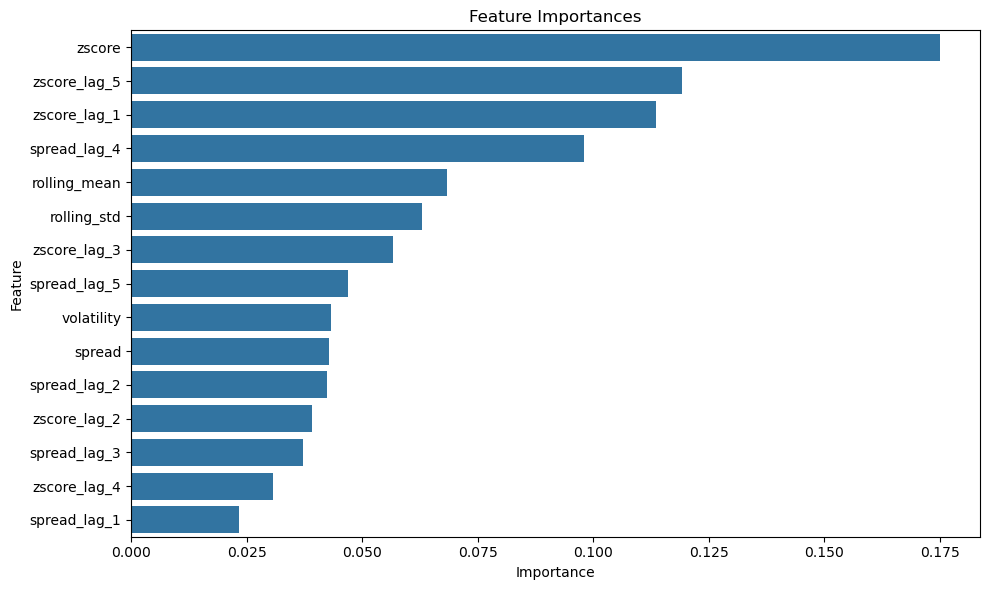

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_dep

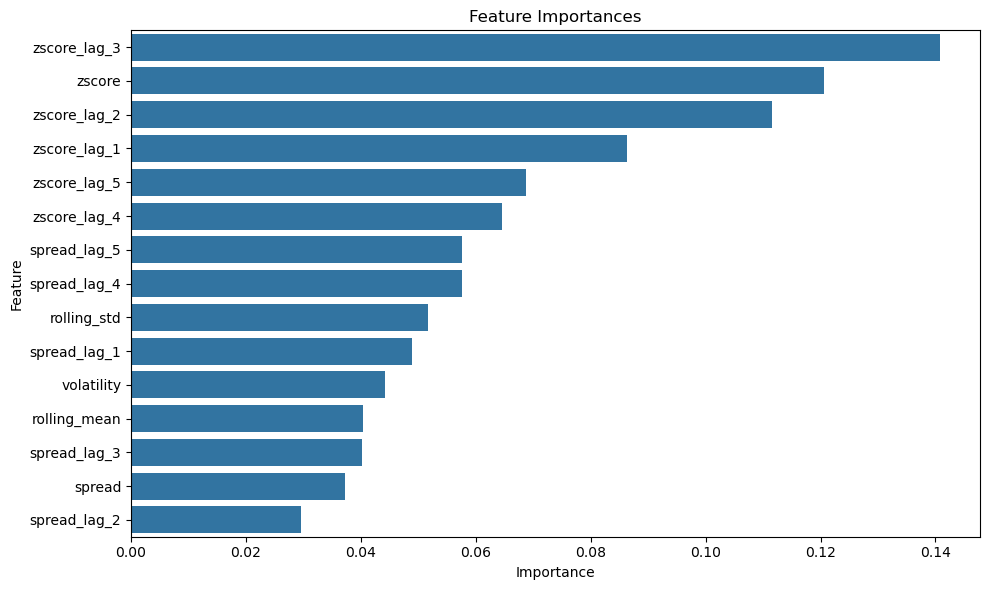

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_dep

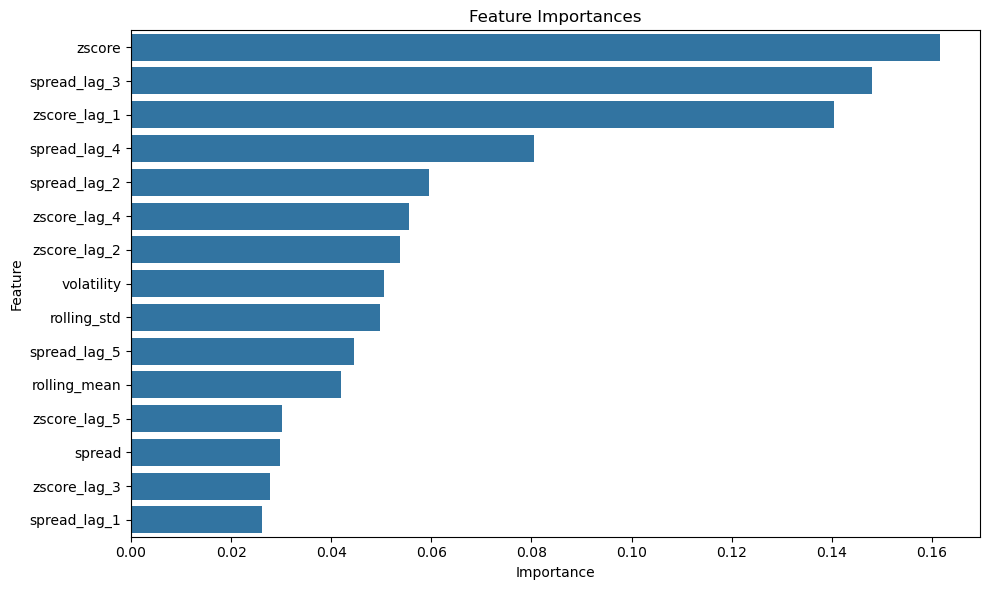

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_dep

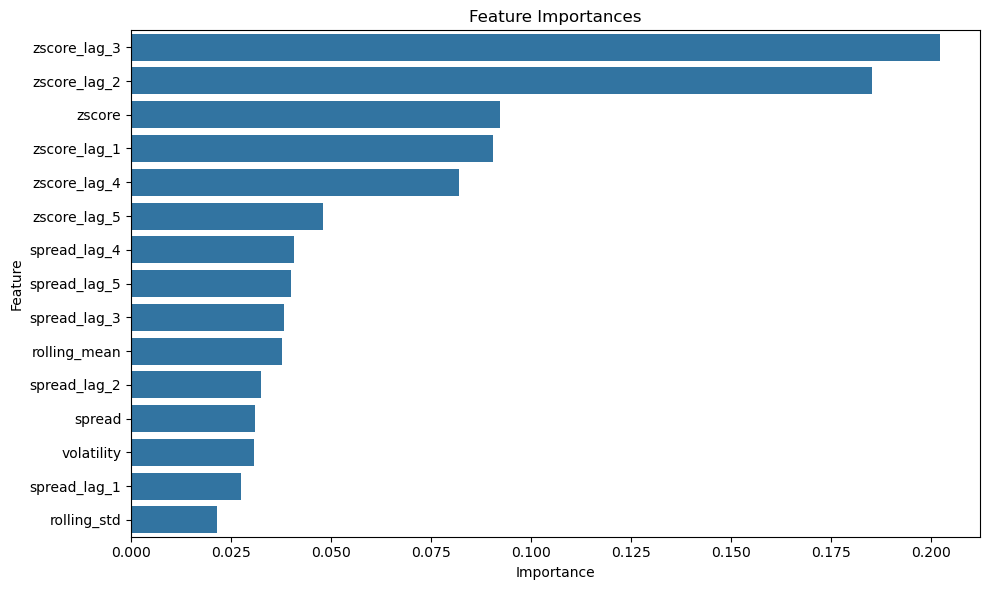

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_dep

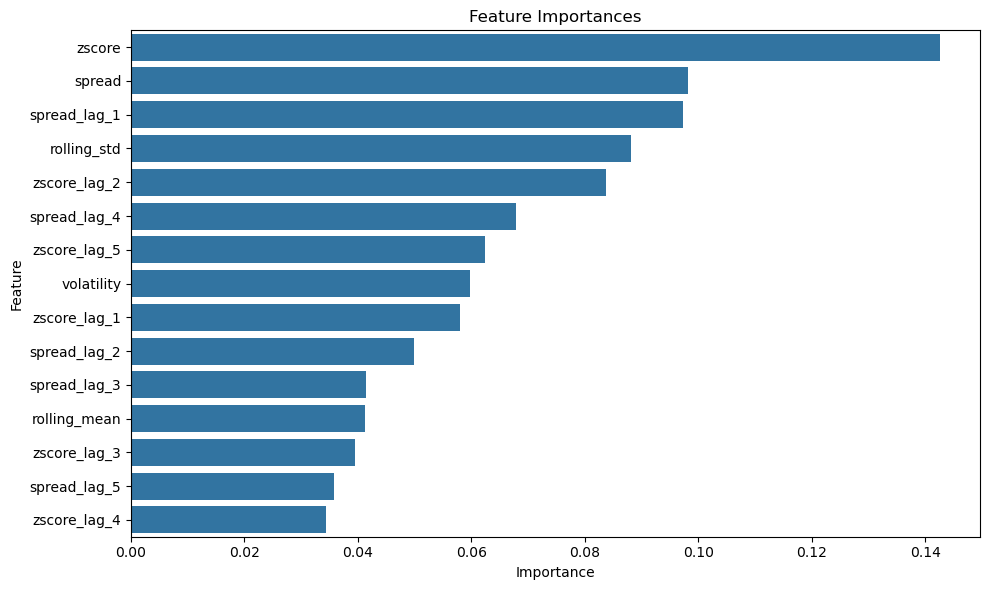

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_dep

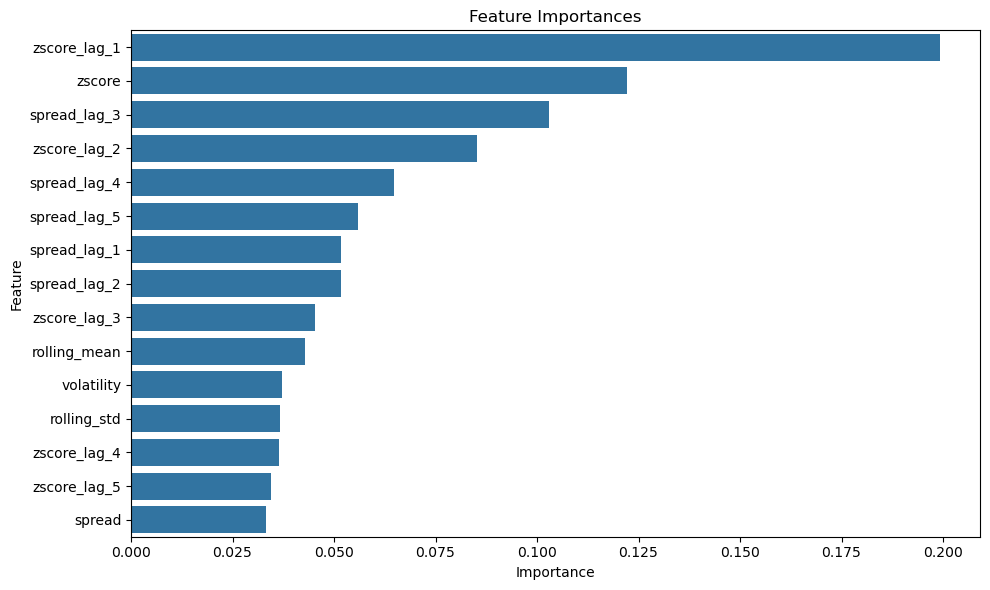

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_dep

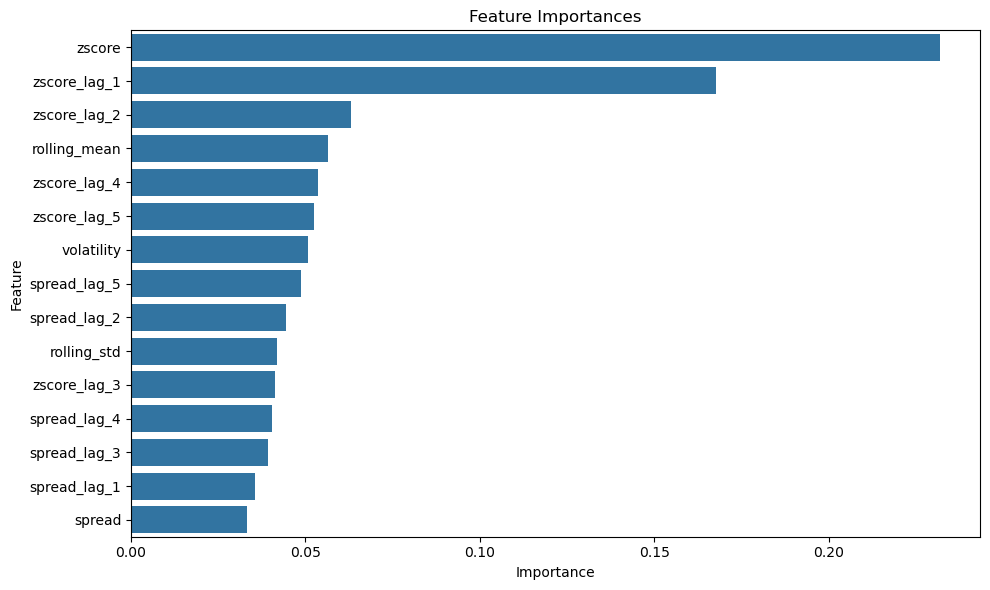

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.2s[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_dept

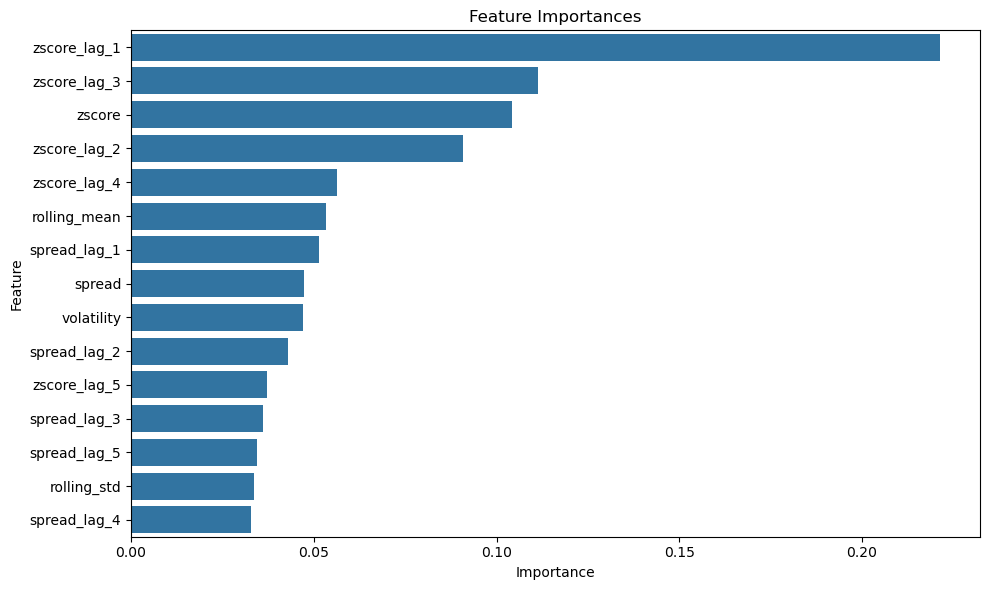

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_dep

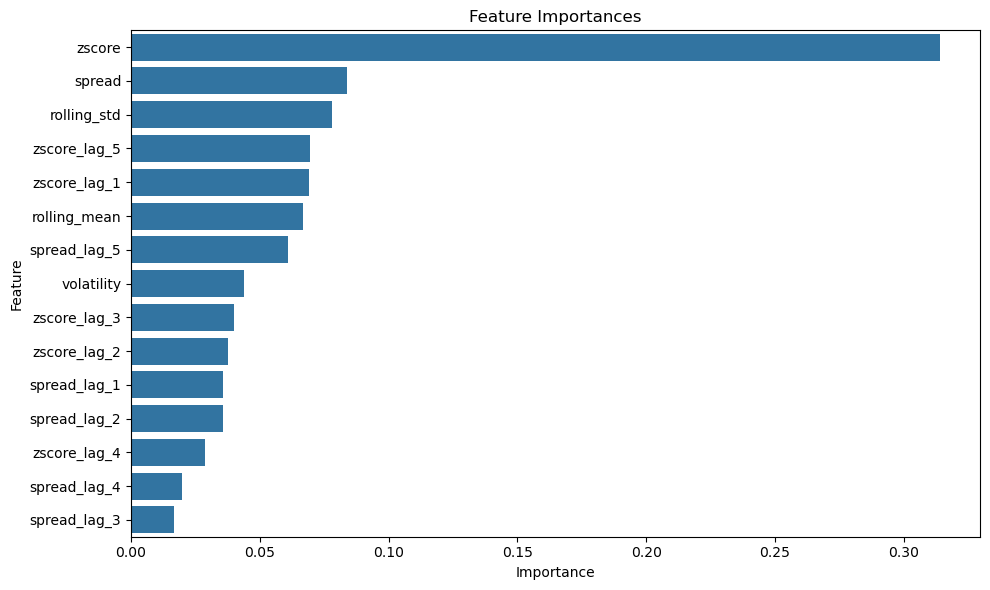

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

stock_pairs = [('F','AVGO'), 
         ('F','JPM'), 
         ('F','XOM'), 
         ('STX','AVGO'), 
         ('STX', 'JPM'),
         ('STX', 'XOM'), 
         ('MO','AVGO'), 
         ('MO', 'JPM'), 
         ('MO','XOM')]

downloadable_tickers = list(set([stock for pair in stock_pairs for stock in pair]))

train_start = "2015-01-01"
train_end = "2020-01-01"
test_start = "2020-01-02"
test_end = "2024-12-31"

train_prices = yf.download(downloadable_tickers, start = train_start, end = train_end)["Close"].dropna()
test_prices = yf.download(downloadable_tickers, start = test_start, end = test_end)["Close"].dropna()

def rolling_zscore(series, window = 60):
    mean = series.rolling(window).mean()
    std = series.rolling(window).std()
    return (series - mean) / std

def predict_mean_reversion_label(
    spread,
    z_window = 60,
    horizon = 10,
    entry_z = 1.0,
    min_pnl = 0.0,
):

    z = rolling_zscore(spread, window = z_window)

    direction = -np.sign(z)

    future_spread = spread.shift(-horizon)

    spread_change = future_spread - spread
    pnl = direction * spread_change

    cond_entry = z.abs() >= entry_z

    labels = ((cond_entry) & (pnl > min_pnl)).astype(float)

    labels = labels.iloc[:-horizon]

    labels = labels.dropna()

    return labels

def process_pair(stock1, stock2, price_data, lookback = 60):
    df = pd.DataFrame(index = price_data.index)
    df["stock1"] = price_data[stock1]
    df["stock2"] = price_data[stock2]

    df["hedge_ratio"] = (
        df["stock1"].rolling(lookback).cov(df["stock2"]) /
        df["stock2"].rolling(lookback).var()
    )

    df["spread"] = df["stock1"] - df["hedge_ratio"] * df["stock2"]
    spread_mean = df["spread"].rolling(lookback).mean()
    spread_std = df["spread"].rolling(lookback).std()
    df["zscore"] = (df["spread"] - spread_mean) / spread_std

    df["rolling_mean"] = spread_mean
    df["rolling_std"] = spread_std
    df["volatility"] = df["spread"].pct_change().rolling(lookback).std()

    for i in range(1, 6):
        df[f"spread_lag_{i}"] = df["spread"].shift(i)
        df[f"zscore_lag_{i}"] = df["zscore"].shift(i)

    labels = predict_mean_reversion_label(df['spread'])
    idx = df.index.intersection(labels.index)
    df = df.loc[idx].copy()
    df['target'] = labels.loc[idx]

    df["pair"] = f"{stock1}_{stock2}"

    return df.dropna()

feature_cols = [
    'spread', 'zscore',
    'rolling_mean', 'rolling_std', 'volatility',
    'spread_lag_1', 'zscore_lag_1',
    'spread_lag_2', 'zscore_lag_2',
    'spread_lag_3', 'zscore_lag_3',
    'spread_lag_4', 'zscore_lag_4',
    'spread_lag_5', 'zscore_lag_5'
]

param_grid = {
    'n_estimators':    [100, 300],
    'max_depth':       [4, 6, 8],
    'gamma':           [0, 1], 
    'learning_rate':   [0.01, 0.05],
    'subsample':       [0.7, 1.0],
    'colsample_bytree':[0.7, 1.0],
    'min_child_weight':[1, 5]
}

cv = TimeSeriesSplit(n_splits = 5)

pair_models = {}

for stock1, stock2 in stock_pairs:
    pair_name = f"{stock1}_{stock2}"

    train_pair = process_pair(stock1, stock2, train_prices)
    test_pair = process_pair(stock1, stock2, test_prices)

    X_train, y_train = train_pair[feature_cols], train_pair["target"]
    X_test, y_test = test_pair[feature_cols], test_pair["target"]

    grid_search = GridSearchCV(
        estimator = XGBClassifier(
            objective = 'binary:logistic',
            eval_metric = 'logloss',
            random_state = 42,
            tree_method = 'hist',
            n_estimators = 300
        ),
        param_grid = param_grid,
        cv = cv,
        scoring = 'f1',
        n_jobs = -1,
        verbose = 2
    )

    grid_search.fit(X_train, y_train)
    best_xgb = grid_search.best_estimator_
    pair_models[pair_name] = best_xgb

    print("\nBest Parameters:", grid_search.best_params_)

    y_pred = best_xgb.predict(X_test)
    y_pred_probs = best_xgb.predict_proba(X_test)[:, 1]

    print("\nClassification Report (Test Data):\n", classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("True Label Distribution:", Counter(y_test))
    print("Predicted Label Distribution:", Counter(y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

    importances = best_xgb.feature_importances_
    feat_imp_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
    feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize = (10, 6))
    sns.barplot(data = feat_imp_df, x = 'Importance', y = 'Feature')
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()

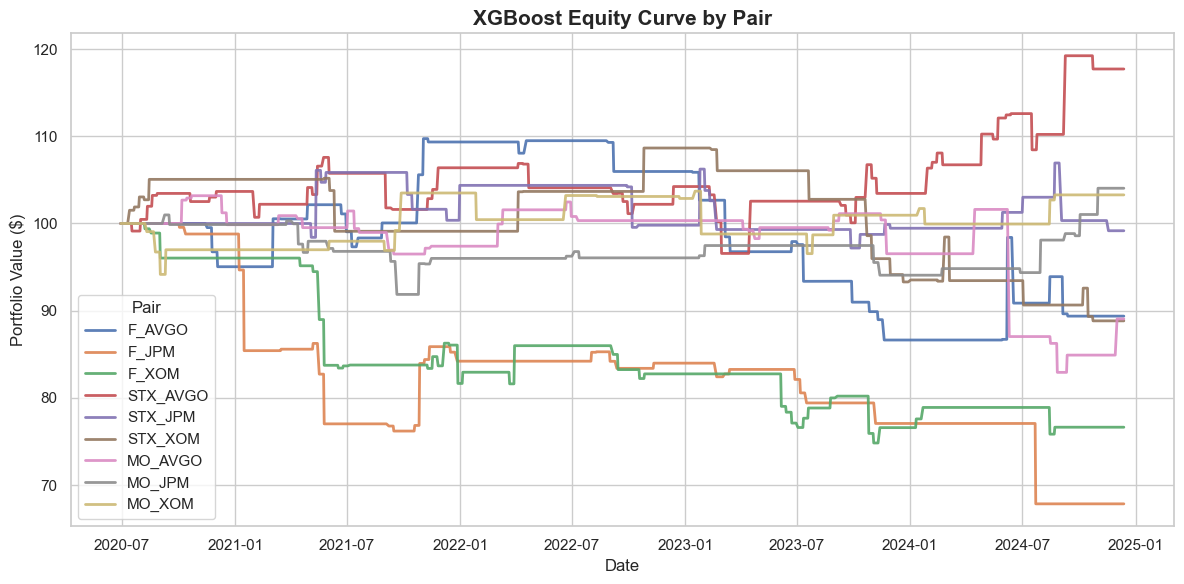

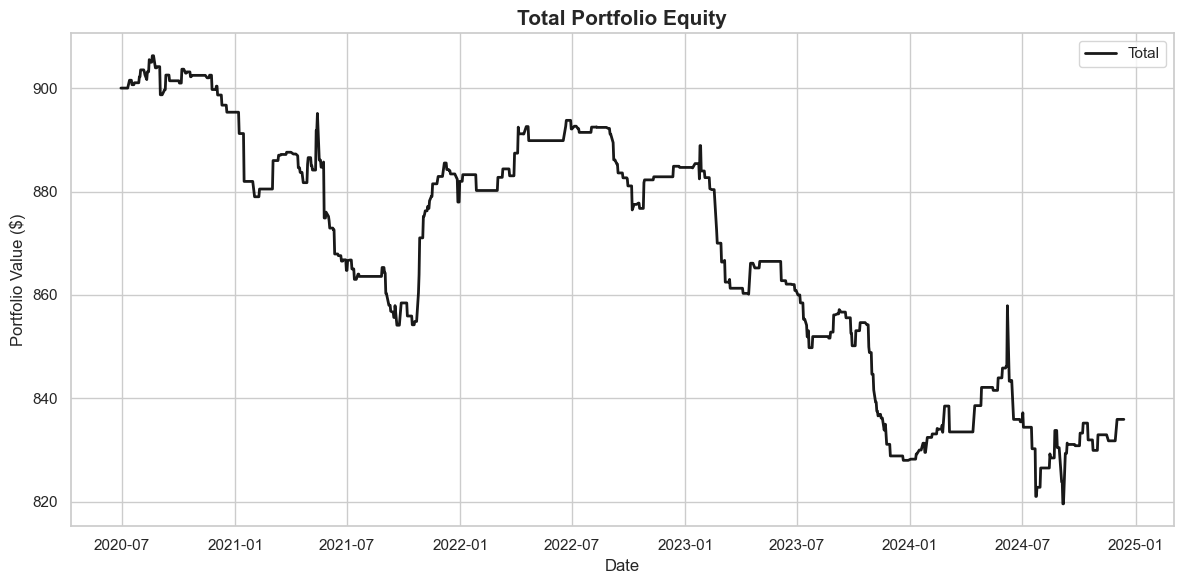

Summary
F_AVGO: Final Value = $89.37, Total Return = -10.63%, Trades = 36
F_JPM: Final Value = $67.84, Total Return = -32.16%, Trades = 29
F_XOM: Final Value = $76.63, Total Return = -23.37%, Trades = 38
STX_AVGO: Final Value = $117.72, Total Return = 17.72%, Trades = 53
STX_JPM: Final Value = $99.17, Total Return = -0.83%, Trades = 24
STX_XOM: Final Value = $88.83, Total Return = -11.17%, Trades = 26
MO_AVGO: Final Value = $89.05, Total Return = -10.95%, Trades = 35
MO_JPM: Final Value = $104.04, Total Return = 4.04%, Trades = 29
MO_XOM: Final Value = $103.28, Total Return = 3.28%, Trades = 21

Total Portfolio Performance
Initial Portfolio Value: $900.00
Final Portfolio Value:   $835.95
Total Return:            -7.12%


In [2]:
def simulate_pair(
    pair_df, 
    initial_cash_per_pair = 100.0, 
    holding_period = 5, 
    entry_threshold = 1.8, 
    use_compounding = True
):
    df = pair_df.sort_index().copy()
    pair_name = df["pair"].iloc[0]
    cash = float(initial_cash_per_pair)

    equity = pd.Series(index = df.index, dtype = float)
    equity.iloc[0] = initial_cash_per_pair
    equity.iloc[:] = np.nan
    equity.iloc[0] = initial_cash_per_pair

    trades = []
    i = 0
    n = len(df)

    while i < n - holding_period:
        row = df.iloc[i]
        prob = row["prob"]

        if (prob >= 0.5) and (abs(row["zscore"]) >= entry_threshold):
            entry_idx = i
            exit_idx = i + holding_period
            entry_date = df.index[entry_idx]
            exit_date = df.index[exit_idx]

            price1_in, price2_in = row["stock1"], row["stock2"]
            price1_out, price2_out = df.iloc[exit_idx]["stock1"], df.iloc[exit_idx]["stock2"]

            notional = cash if use_compounding else initial_cash_per_pair
            long_dollars, short_dollars = notional / 2.0, notional / 2.0

            if row["zscore"] > 0:
                shares_short1 = short_dollars / price1_in
                shares_long2  = long_dollars / price2_in
                pnl = (shares_long2 * (price2_out - price2_in)) + (shares_short1 * (price1_in - price1_out))
                direction = "Short 1 / Long 2"
            else:
                shares_long1  = long_dollars / price1_in
                shares_short2 = short_dollars / price2_in
                pnl = (shares_long1 * (price1_out - price1_in)) + (shares_short2 * (price2_in - price2_out))
                direction = "Long 1 / Short 2"

            cash += pnl
            equity.loc[entry_date:exit_date] = cash

            trades.append({
                "pair": pair_name,
                "entry_date": entry_date,
                "exit_date": exit_date,
                "direction": direction,
                "pnl": float(pnl),
                "notional": float(notional)
            })

            i = exit_idx + 1
        else:
            equity.iloc[i] = cash
            i += 1

    equity.ffill(inplace=True)
    return equity, trades


pair_results = []
initial_cash_per_pair = 100.0

for stock1, stock2 in stock_pairs:
    pair_name = f"{stock1}_{stock2}"

    test_pair = process_pair(stock1, stock2, test_prices).copy()

    model = pair_models[pair_name]

    X_test_pair = test_pair[feature_cols]
    test_pair['prediction'] = model.predict(X_test_pair)
    test_pair['prob'] = model.predict_proba(X_test_pair)[:, 1]

    equity, trades = simulate_pair(test_pair)

    pair_results.append({
        "pair": pair_name,
        "equity": equity,
        "trades": trades,
        "final_value": equity.iloc[-1],
        "total_return": (equity.iloc[-1] / equity.iloc[0] - 1) * 100,
        "n_trades": len(trades)
    })


sns.set_theme(style = "whitegrid", context = "notebook")

plt.figure(figsize = (12, 6))
combined_equity = 0

for result in pair_results:
    sns.lineplot(
        x = result["equity"].index,
        y = result["equity"].values,
        label = result["pair"],
        linewidth = 2,
        alpha = 0.9
    )
    if isinstance(combined_equity, int):
        combined_equity = result["equity"]
    else:
        combined_equity = combined_equity.add(result["equity"], fill_value = 0)

plt.title("XGBoost Equity Curve by Pair", fontsize = 15, weight = "bold")
plt.xlabel("Date", fontsize = 12)
plt.ylabel("Portfolio Value ($)", fontsize = 12)
plt.legend(title = "Pair", frameon = True)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize = (12, 6))
sns.lineplot(
    x = combined_equity.index,
    y = combined_equity.values,
    label = "Total",
    color = "black",
    linewidth = 2,
    alpha = 0.9
)
plt.title("Total Portfolio Equity", fontsize = 15, weight = "bold")
plt.xlabel("Date", fontsize = 12)
plt.ylabel("Portfolio Value ($)", fontsize = 12)
plt.legend(frameon = True)
plt.grid(True)
plt.tight_layout()
plt.show()

print("Summary")
for result in pair_results:
    print(f"{result['pair']}: Final Value = ${result['final_value']:.2f}, "
          f"Total Return = {result['total_return']:.2f}%, Trades = {result['n_trades']}")

initial_total_value = combined_equity.iloc[0]
final_total_value = combined_equity.iloc[-1]
total_return_pct = (final_total_value - initial_total_value) / initial_total_value * 100

print("\nTotal Portfolio Performance")
print(f"Initial Portfolio Value: ${initial_total_value:,.2f}")
print(f"Final Portfolio Value:   ${final_total_value:,.2f}")
print(f"Total Return:            {total_return_pct:.2f}%")

In [3]:
def compute_sharpe_ratio(equity_series):
    daily_returns = equity_series.pct_change().dropna()
    mean_return = daily_returns.mean()
    std_return = daily_returns.std()
    sharpe = (mean_return / std_return) * np.sqrt(252) if std_return > 0 else np.nan
    return sharpe

print("\nSharpe Ratios")
for result in pair_results:
    sharpe = compute_sharpe_ratio(result["equity"])
    result["sharpe"] = sharpe
    print(f"{result['pair']}: Sharpe Ratio = {sharpe:.2f}")

portfolio_sharpe = compute_sharpe_ratio(combined_equity)
print(f"\nTotal Portfolio Sharpe Ratio: {portfolio_sharpe:.2f}")



Sharpe Ratios
F_AVGO: Sharpe Ratio = -0.20
F_JPM: Sharpe Ratio = -0.83
F_XOM: Sharpe Ratio = -0.76
STX_AVGO: Sharpe Ratio = 0.50
STX_JPM: Sharpe Ratio = 0.01
STX_XOM: Sharpe Ratio = -0.36
MO_AVGO: Sharpe Ratio = -0.25
MO_JPM: Sharpe Ratio = 0.23
MO_XOM: Sharpe Ratio = 0.17

Total Portfolio Sharpe Ratio: -0.62


In [4]:
def compute_max_drawdown(equity_curve):
    cumulative_max = equity_curve.cummax()
    drawdown = (equity_curve - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()
    print(f"\nMax Drawdown: {max_drawdown:.2%}")
    return max_drawdown

max_drawdown = compute_max_drawdown(combined_equity)



Max Drawdown: -9.56%


Exception ignored in: <function ResourceTracker.__del__ at 0x10ceeda80>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10d61da80>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child proces